# <a id='toc1_'></a>[NCF Model](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [NCF Model](#toc1_)    
  - [Importing Libraries and Datasets](#toc1_1_)    
  - [Filtering user data](#toc1_2_)    
  - [Train Test Split](#toc1_3_)    
  - [Converting to Implicit Feedback Scores](#toc1_4_)    
  - [Adding Negative Class](#toc1_5_)    
  - [Modelling](#toc1_6_)    
  - [Evaluating the Model](#toc1_7_)    
  - [Acknowledgements](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Importing Libraries and Datasets](#toc0_)

In [1]:
# the holy tinity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scraping tools for Steam User data
import scraping_tools as st

# we don't like warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
games_df = pd.read_csv('data/clean_game_data.csv')
users_df = pd.read_csv('data/clean_user_data.csv')
recs_df = pd.read_csv('data/clean_recommendations.csv')

In [3]:
games_df.head(3)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,...,t_Well-Written,t_Werewolves,t_Western,t_Wholesome,t_Word Game,t_World War I,t_World War II,t_Wrestling,t_Zombies,t_eSports
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,1,92,37039,19.99,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,1,84,2199,9.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22364,BRINK: Agents of Change,2011-08-03,1,0,0,1,85,21,2.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
users_df.head(3)

,user_id,products,reviews
0,6924278,156,1
1,4358034,329,4
2,2340634,176,2


In [5]:
recs_df.head(3)

,app_id,helpful,funny,review_date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,24170,0
1,304390,4,0,2017-02-17,0,11.5,1339,1
2,1085660,2,0,2019-11-17,1,336.5,110271,2


In [10]:
# some useful stats about users and games
print('The total number of games:', games_df['app_id'].nunique())
print('The total number of users:', users_df['user_id'].nunique())
print('The total number of game recommendations:', recs_df['app_id'].count())
print('The unique number of recommenders:', recs_df['user_id'].nunique())
print('The unique number of games recommended:', recs_df['app_id'].nunique())


The total number of games: 48844
The total number of users: 7067002
The total number of game recommendations: 14585291
The unique number of recommenders: 6903784
The unique number of games recommended: 2266


## <a id='toc1_2_'></a>[Filtering user data](#toc0_)

Without cloud computing, handling this many reviews will be next to impossible.  So, we need a way to filter the recommendations dataset significantly.  One way to do that is to remove users with only a few reviews since we are less likely to be able to learn anything important about those users.

There are roughly 7 million users and 14.5 million total recommendations. On average, then, users in this dataset review only 2 games.  Not really enough to learn anything interesting about the users.  For this reason, let's filter our users to only include users with 10 or more reviews.  The `users_df` tells us the user_id and the number of reviews that users has left.  So, we'll find the users with 10 or more reviews from `users_df` to filter the `recs_df` to include only those users.

In [20]:
# number of recommenders with 10 or more recommendations from users_df
rec10 = users_df[users_df['reviews']>=10]
print('Number of unique users with 10 or more reviews:', rec10['user_id'].nunique())

Number of unique users with 10 or more reviews: 151871


In [21]:
recs_df = recs_df.merge(rec10, on='user_id')
recs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2505749 entries, 0 to 2505748
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   review_date     object 
 4   is_recommended  int64  
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   products        int64  
 9   reviews         int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 210.3+ MB


After filtering the recommendations, we are left with 151,871 unique users and 2.5 million total reviews. That gives us ~16.5 reviews per unique user_id. That should still be plenty of reviews for modelling.  We might, however, have lost games from our list of reviewed games.  Let's check:

In [22]:
# get number of games reviewed in the filtered recommendations df
recs_df['app_id'].nunique()

2253

By filtering our recs_df to only include users with 10 or more reviews, we end up losing 13 games from our list of reviewed games.  In other words, those 13 games were only reviewed by users who had reviewed less than 10 total games.

Now that we have this data.  I will export the important parts for modelling to a csv that can be used later.

In [133]:
ncf_df = recs_df[['user_id', 'app_id', 'is_recommended']]
ncf_df.to_csv('data/ncf_recommendations.csv')

Finally, let's get an idea of which games are the most popular from our dataset.

In [134]:
recs_df.head()

,app_id,helpful,funny,review_date,is_recommended,hours,user_id,review_id,products,reviews,review_order
0,534380,0,0,2022-10-08,1,40.6,10531,22,217,15,3.0
1,289070,0,0,2020-12-14,1,197.0,10531,771919,217,15,14.0
2,1145360,0,0,2021-03-04,1,36.9,10531,1753530,217,15,11.0
3,221680,0,0,2021-11-30,1,204.5,10531,2481634,217,15,9.0
4,1142710,0,0,2022-03-21,1,43.8,10531,3668404,217,15,8.0


In [155]:
# look at the 20 most popular games
popular_games = recs_df['app_id'].value_counts().sort_values(ascending=False)[0:20]
# find titles
app_titles = games_df['title'].loc[games_df['app_id'].isin(popular_games.index)]

# add everything to a dataframe
popular_games_df = pd.DataFrame({'app_id': popular_games.index, 'title': app_titles.values, 'num_reviews': popular_games.values})
display(popular_games_df)

,app_id,title,num_reviews
0,377160,Garry's Mod,25409
1,275850,Halo: The Master Chief Collection,22239
2,1091500,Rust,19506
3,271590,DARK SOULS™ III,19340
4,1174180,Grand Theft Auto V,17621
5,431960,Killing Floor 2,17177
6,292030,The Witcher® 3: Wild Hunt,16172
7,49520,No Man's Sky,16144
8,252490,Divinity: Original Sin 2 - Definitive Edition,15029
9,107410,Far Cry® 5,14514


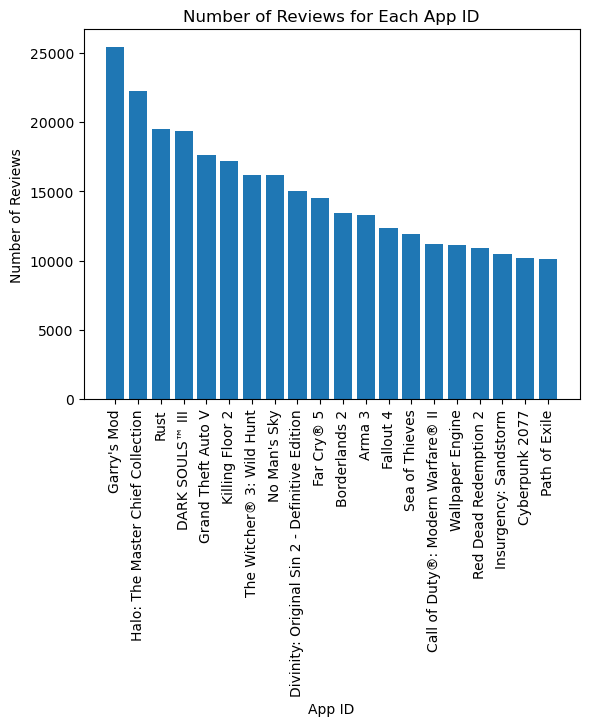

In [159]:
plt.bar(popular_games_df['title'], popular_games_df['num_reviews'])
plt.xlabel('App ID')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each App ID')
plt.xticks(rotation=90)
plt.show()

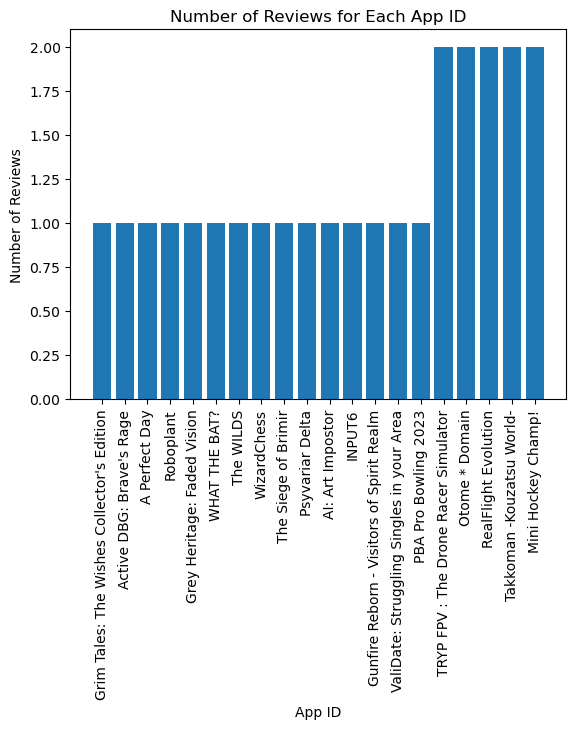

In [161]:
# look at the least popular as well
popular_games = recs_df['app_id'].value_counts().sort_values(ascending=True)[0:20]
# find titles
app_titles = games_df['title'].loc[games_df['app_id'].isin(popular_games.index)]

# add everything to a dataframe
least_popular_games_df = pd.DataFrame({'app_id': popular_games.index, 'title': app_titles.values, 'num_reviews': popular_games.values})

plt.bar(least_popular_games_df['title'], least_popular_games_df['num_reviews'])
plt.xlabel('App ID')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each App ID')
plt.xticks(rotation=90)
plt.show()

As we can see, some of the most popular games have more than 15,000 reviews while the least popular games in our dataset have 1-2 reviews.  Training models on this dataset, then, will almost certainly bias the model toward the more popular games.  Various strategies for avoiding this problem exist.  For this model, I will predict the top 100 games for each user, and then randomly select 6 of those to be displayed.  This does not solve the issue, but it might help to mitigate it.

## <a id='toc1_3_'></a>[Train Test Split](#toc0_)

For this sort of recommender system, we want to make sure our train split isn't using a user's most recent review since that is the one that is most relevant to their real-world preferences.  So, we'll get our train-test split by removing the most recent review from each user for our test split.

In [23]:
# converting review_date to datetime
recs_df['review_date'] = pd.to_datetime(recs_df['review_date'])
recs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2505749 entries, 0 to 2505748
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          int64         
 1   helpful         int64         
 2   funny           int64         
 3   review_date     datetime64[ns]
 4   is_recommended  int64         
 5   hours           float64       
 6   user_id         int64         
 7   review_id       int64         
 8   products        int64         
 9   reviews         int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 210.3 MB


In [27]:
# adding review date ordering
recs_df['review_order'] = recs_df.groupby(['user_id'])['review_date'].rank(method='first', ascending=False)

In [31]:
# check a random user to ensure ranking worked
recs_df[recs_df['user_id'] == 10531].sort_values(by='review_date', ascending=False)

,app_id,helpful,funny,review_date,is_recommended,hours,user_id,review_id,products,reviews,review_order
8,1794680,0,0,2022-10-20,1,15.1,10531,5948728,217,15,1.0
9,1113000,0,0,2022-10-09,1,20.1,10531,6950566,217,15,2.0
0,534380,0,0,2022-10-08,1,40.6,10531,22,217,15,3.0
5,397540,0,0,2022-10-08,1,23.6,10531,4168712,217,15,4.0
7,394360,138,30,2022-10-08,1,135.1,10531,4914992,217,15,5.0
11,49520,0,0,2022-10-08,1,193.0,10531,12863493,217,15,6.0
12,239140,0,0,2022-10-08,1,39.8,10531,14170788,217,15,7.0
4,1142710,0,0,2022-03-21,1,43.8,10531,3668404,217,15,8.0
3,221680,0,0,2021-11-30,1,204.5,10531,2481634,217,15,9.0
10,945360,0,0,2021-09-20,1,14.0,10531,11896248,217,15,10.0


In [32]:
# define our train/test split
train_recs = recs_df[recs_df['review_order'] != 1]
test_recs = recs_df[recs_df['review_order'] == 1]

# drop columns that we won't be using
train_recs = train_recs[['user_id', 'app_id', 'is_recommended']]
test_recs = test_recs[['user_id', 'app_id', 'is_recommended']]

## <a id='toc1_4_'></a>[Converting to Implicit Feedback Scores](#toc0_)

This recommender system is only interested in if you would be willing to click on the game.  Since you were willing to click on the game even though you might not have liked it, that game still counts as a positive game in this case.  So, we will convert all 'is_recommended' values to 1.

In [35]:
# convert all 'is_recommended' values to 1
train_recs.loc[:, 'is_recommended'] = 1

In [36]:
# confirm it worked
train_recs['is_recommended'].describe()

count    2353878.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: is_recommended, dtype: float64

## <a id='toc1_5_'></a>[Adding Negative Class](#toc0_)

Since all of our training data is now a positive case (all reviews are positive reviews), we need to add some negative reviews.  To do this, we'll add negative reviews for each user.  I will arbitrarily choose 4 'negative' reviews per user by selecting 4 games for each user that they have not reviewed.

N.B.: This assumes the user would not click on one of the games they did not review.  Clearly that is an oversimplification, but it provides a method of testing the data as we will later see.

In [64]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import random

In [40]:
class GamesTrainSet(Dataset):
    """Games PyTorch Dataset for Training
    
    Args:
        recs_df (pd.DataFrame): Dataframe containing the game ratings
        all_game_ids (list): List containing all game ids
    
    """

    def __init__(self, recs_df, all_game_ids):
        self.users, self.items, self.labels = self.get_dataset(recs_df, all_game_ids)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, recs_df, all_game_ids):
        users, items, labels = [], [], []
        user_item_set = set(zip(recs_df['user_id'], recs_df['app_id']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_game_ids)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_game_ids)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

## <a id='toc1_6_'></a>[Modelling](#toc0_)

In [53]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            recs_df (pd.DataFrame): Dataframe containing the movie ratings for training
            all_game_ids (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, recs_df, all_game_ids):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.recs_df = recs_df
        self.all_game_ids = all_game_ids
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(GamesTrainSet(self.recs_df, self.all_game_ids),
                          batch_size=256, num_workers=0)

In [54]:
num_users = recs_df['user_id'].max()+1
num_items = recs_df['app_id'].max()+1

# get a list of all game ids
all_game_ids = recs_df['app_id'].unique()

model = NCF(num_users, num_items, train_recs, all_game_ids)

In [55]:
trainer = pl.Trainer(max_epochs=2)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 56.5 M
1 | item_embedding | Embedding | 17.8 M
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
74.3 M    Trainable params
0         Non-trainable params
74.3 M    Total params
297.222   Total estimated model params size (MB)


Epoch 1: 100%|██████████| 45975/45975 [9:36:38<00:00,  1.33it/s, v_num=2]  

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 45975/45975 [9:36:46<00:00,  1.33it/s, v_num=2]


In [56]:
# save this model
torch.save(model.state_dict(), 'ncf_model.pth')

## <a id='toc1_7_'></a>[Evaluating the Model](#toc0_)

Traditional methods of evaluating models include calculating the model's accuracy, recall, precision, f1 score, RMSE, etc.  Finding the accuracy, or RMSE, of a recommender system, however, doesn't make much sense when we are trying to determine a user's preferences and not, say, a simple logistic regression problem.  For this reason, we try to find a list of, for instance, 10 items that the user would interact with (given the combination of the item vector and user vector that the model trained on).  To do this, we pick 100 random items, all of which the user has not interacted with _except one_ (the one we split out during the train/test split).  We then get the model to determine the top 10 items that it thinks the user is likely to interact with.  If it successfully picks the one that we know the user interacted with, then the recommendations were a success.  The more consistently it manages to predict a top 10 containing that 1 item, the better the model.  This is called a Hit Ratio @ 10.

Let's implement this evaluation below.

In [57]:
from tqdm import tqdm

In [58]:
# User-item pairs for testing
test_user_item_set = set(zip(test_recs['user_id'], test_recs['app_id']))

# Dict of all items that are interacted with by each user
user_interacted_items = recs_df.groupby('user_id')['app_id'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_game_ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 151871/151871 [03:02<00:00, 830.79it/s]

The Hit Ratio @ 10 is 0.50


This model has a HR@10 of 0.5, which means that, from 100 items, it has a 50% chance of picking our known item in its top 10.  This is significantly better than random chance--the chance of randomly selecting a given item from a pool of 100 in 10 tries (without replacement), is ~9.52%.  So, we have good reason to be optimistic about this model.  Given the training cycle of only 2 epochs (which took my computer ~19 hours), it is possible that this model could continue to be improved.

For now, let's take a random user and see which games it predicts for that user.

In [90]:
# get a random user_id to get recommendations for
test_user = np.random.choice(recs_df['user_id'])

print(test_user)

3046002


In [91]:
# find this user's games
test_users_games = user_interacted_items.get(test_user, [])

# find the games they haven't interacted with
candidate_games = list(set(all_game_ids) - set(test_users_games))

# convert to tensor
test_user = torch.tensor([test_user]*len(candidate_games))
candidate_games = torch.tensor(candidate_games)

print(test_user)
print(candidate_games)


tensor([3046002, 3046002, 3046002,  ..., 3046002, 3046002, 3046002])
tensor([868360, 909320,     10,  ...,  32750, 753650, 434170])


In [96]:
# make predictions
predictions = np.squeeze(model(test_user, candidate_games).detach().numpy())

In [127]:
# get the top 10 game ids and their scores for our test user
top10_predictions = [candidate_games[i] for i in np.argsort(predictions)[::-1][0:10].tolist()]
top10_scores = [predictions[i] for i in np.argsort(predictions)[::-1][0:10].tolist()]

# get number values for the top10 predictions
recommended_appIDs = [str(tensor).split('(')[1].split(')')[0] for tensor in top10_predictions]
recommended_appIDs = [int(value) for value in recommended_appIDs]

# get the corresponding titles for those app_ids
test_titles = games_df['title'].loc[games_df['app_id'].isin(recommended_appIDs)].values

In [128]:
test_recommenations = pd.DataFrame({
    'app_id': recommended_appIDs,
    'title' : test_titles,
    'score' : top10_scores
})

display(test_recommenations)

,app_id,title,score
0,377160,Halo: The Master Chief Collection,0.846122
1,271590,Rust,0.806305
2,49520,Space Engineers,0.788712
3,431960,Grand Theft Auto V,0.788633
4,252490,The Witcher® 3: Wild Hunt,0.771344
5,1174180,Borderlands 2,0.768276
6,292030,Arma 3,0.760255
7,976730,Fallout 4,0.744673
8,107410,Wallpaper Engine,0.736670
9,244850,Red Dead Redemption 2,0.727971


These are the top 10 games that are recommended to the user.  They seem like normal (and usually popular) games, but it's hard to say anything about the quality of those recommendations without also seeing the games that this user has already interacted with.  Let's compare it, then, to the user's played history.

In [130]:
test_users_games_df = pd.DataFrame({
    'app_id': test_users_games,
    'title' : games_df['title'].loc[games_df['app_id'].isin(test_users_games)].values,
})

display(test_users_games_df)

,app_id,title
0,1091500,Stray
1,534380,Microsoft Flight Simulator 40th Anniversary Ed...
2,1817070,DOOM
3,1240440,Monster Prom 2: Monster Camp
4,275850,Among Us
5,359550,God of War
6,397540,Dying Light 2 Stay Human
7,1332010,Halo Infinite
8,1250410,No Man's Sky
9,1140270,Death Road to Canada


At least some of these games are very close to the user's recommended games.  God of War is certainly similar to The Witcher 3, for instance, while Space Engineers shares many qualities with No Man's Sky.  Importantly, these games are quite varied in style or gameplay while also being closely related to some of the games the user has already played.  So, while the Hit Ratio @ 10 could be improved (possibly with further training and more epochs), the recommendations seem decent.

## <a id='toc1_8_'></a>[Acknowledgements](#toc0_)

I learned how to create this model by following a wonderful guide by James Loy found <a href='https://towardsdatascience.com/deep-learning-based-recommender-systems-3d120201db7e'>here</a>, where he goes into detail about the benefits and drawbacks of an implicit feedback system, user and item embeddings, and the collaborative filtering process.